#  Learn Modulation and Demodulation in Nonlinear Channels with Deep Neural Networks by Autoencoders and End-to-end Training

This code is provided as supplementary material of the lecture Machine Learning and Optimization in Communications (MLOC).<br>

This code illustrates
* End-to-end-learning of modulation scheme and demodulator in a simple nonlinear channel model with time-varying batch size

In [1]:
import tensorflow as tf
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
from ipywidgets import interactive
import ipywidgets as widgets

Specify the parameters of the transmission as the fiber length $L$ (in km), the fiber nonlinearity coefficienty $\gamma$ (given in 1/W/km) and the total noise power $P_n$ (given in dBM. The noise is due to amplified spontaneous emission in amplifiers along the link). We assume a model of a dispersion-less fiber affected by nonlinearity. The model, which is described for instance in [1] is given by an iterative application of the equation
$$
x_{k+1} = x_k\exp\left(\jmath\frac{L}{K}\gamma|x_k|^2\right) + n_{k+1},\qquad 0 \leq k < K
$$
where $x_0$ is the channel input (the modulated, complex symbols) and $x_K$ is the channel output. $K$ denotes the number of steps taken to simulate the channel Usually $K=50$ gives a good approximation.

[1] S. Li, C. Häger, N. Garcia, and H. Wymeersch, "Achievable Information Rates for Nonlinear Fiber Communication via End-to-end Autoencoder Learning," Proc. ECOC, Rome, Sep. 2018

In [2]:
# Length of transmission (in km)
L = 5000

# fiber nonlinearity coefficient
gamma = 1.27

Pn = -21.3 # noise power (in dBm)

Kstep = 50 # number of steps used in the channel model

# noise variance per step    
sigma_n = np.sqrt((10**((Pn-30)/10)) / Kstep / 2)    


def simulate_channel(x, Pin, constellation):  
    # modulate bpsk
    input_power_linear = 10**((Pin-30)/10)
    norm_factor = 1 / np.sqrt(np.mean(np.abs(constellation)**2)/input_power_linear)
    modulated = constellation[x] * norm_factor
    

    temp = np.array(modulated, copy=True)
    for i in range(Kstep):
        power = np.absolute(temp)**2
        rotcoff = (L / Kstep) * gamma * power
        
        temp = temp * np.exp(1j*rotcoff) + sigma_n*(np.random.randn(len(x)) + 1j*np.random.randn(len(x)))
    return temp

Helper function to compute Bit Error Rate (BER)

In [3]:
# helper function to compute the symbol error rate
def SER(predictions, labels):
    return (np.sum(np.argmax(predictions, 1) != labels) / predictions.shape[0])

Here, we define the parameters of the neural network and training, generate the validation set and a helping set to show the decision regions

In [4]:
# set input power
Pin = 4
input_power_linear = 10**((Pin-30)/10)

# number of points in constellation
M = 16


# validation set. Training examples are generated on the fly
N_valid = 100000

# number of neurons in hidden layers at transmitter
hidden_neurons_TX_1 = 50
hidden_neurons_TX_2 = 50
hidden_neurons_TX_3 = 50
hidden_neurons_TX_4 = 50

# number of neurons in hidden layers at receiver
hidden_neurons_RX_1 = 50
hidden_neurons_RX_2 = 50
hidden_neurons_RX_3 = 50
hidden_neurons_RX_4 = 50



y_valid = np.random.randint(M,size=N_valid)
y_valid_onehot = np.eye(M)[y_valid]

# meshgrid for plotting
# assume that the worst case constellation is the one where all points lie on a straight line starting at the center and then are spreaded equidistantly. In this case, this is the scaling factor of the constellation points and we assume that there is an (M+1)th point which defines ext_max 
ext_max = np.sqrt(M*input_power_linear)
mgx,mgy = np.meshgrid(np.linspace(-ext_max,ext_max,400), np.linspace(-ext_max,ext_max,400))
meshgrid = np.column_stack((np.reshape(mgx,-1,1),np.reshape(mgy,-1,1))) 

This is the main function of TensorFlow that generates the computation graph. We have a single interface to the outside (a `tf.placeholder` which is the batch size. Here the idea is to vary the batch size during training. In the first iterations, we start with a small batch size to rapidly get to a working solution. The closer we come towards the end of the training we increase the batch size. If keeping the abtch size small, it may happen that there are no misclassifications in a small batch and there is no incentive of the training to improve. A larger batch size will most likely contain errors in the batch and hence there will be incentive to keep on training and improving. 

Here, the data is generated on the fly inside the graph, by using TensorFlows random number generation. As TensorFlow does not natively support complex numbers (at least in early versions), we decided to replace the complex number operations in the channel by a simple rotation matrix and treating real and imaginary parts separately.

We use the ELU activation function inside the neural network and employ the Adam optimization algorithm.

In [5]:
# generate graph
graph = tf.Graph()

with graph.as_default():    
    # placeholder for training data (passed from external)
    tf_batch_size = tf.placeholder(tf.int32, shape=())

    # the validation dataset, we only have labels
    tf_valid_labels = tf.constant(y_valid_onehot, dtype=tf.float32)

    # temporary identity matrix for one-hot vector conversion
    tf_onehot_conversion = tf.constant(np.eye(M), dtype=tf.float32)
    
    # the mesgrid for plotting the decision region
    tf_meshgrid = tf.constant(meshgrid, dtype=tf.float32)
    
    # define weights
    Ws = {
        'T1' : tf.Variable(tf.truncated_normal([M,hidden_neurons_TX_1], stddev=0.8)),
        'T2' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_1, hidden_neurons_TX_2], stddev=0.8)),
        'T3' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_2, hidden_neurons_TX_3], stddev=0.8)),
        'T4' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_3, hidden_neurons_TX_4], stddev=0.8)),
        'T5' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_4, 2], stddev=0.8)),
        'R1' : tf.Variable(tf.truncated_normal([2,hidden_neurons_RX_1], stddev=0.8)),
        'R2' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_1, hidden_neurons_RX_2], stddev=0.8)),
        'R3' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_2, hidden_neurons_RX_3], stddev=0.8)),
        'R4' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_3, hidden_neurons_RX_4], stddev=0.8)),
        'R5' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_4, M], stddev=0.8))
        }

    bs = {
        'T1' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_1], stddev=0.8)),
        'T2' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_2], stddev=0.8)),
        'T3' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_3], stddev=0.8)),
        'T4' : tf.Variable(tf.truncated_normal([hidden_neurons_TX_4], stddev=0.8)),
        'T5' : tf.Variable(tf.truncated_normal([2], stddev=0.8)),
        'R1' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_1], stddev=0.8)),
        'R2' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_2], stddev=0.8)),
        'R3' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_3], stddev=0.8)),
        'R4' : tf.Variable(tf.truncated_normal([hidden_neurons_RX_4], stddev=0.8)),
        'R5' : tf.Variable(tf.truncated_normal([M], stddev=0.8))
    }
        
    

    def network_transmitter(batch_labels):
        nn = tf.nn.elu(tf.matmul(batch_labels, Ws['T1'])+bs['T1'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['T2'])+bs['T2'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['T3'])+bs['T3'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['T4'])+bs['T4'])
        nn = tf.matmul(nn, Ws['T5'])+bs['T5']
        return nn

    def network_receiver(inp):
        nn = tf.nn.elu(tf.matmul(inp, Ws['R1'])+bs['R1'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['R2'])+bs['R2'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['R3'])+bs['R3'])
        nn = tf.nn.elu(tf.matmul(nn, Ws['R4'])+bs['R4'])
        logits = tf.matmul(nn, Ws['R5'])+bs['R5']
        return logits
    
    def channel_model(modulated):
        # simulate the channel
        for i in range(Kstep):
            power = tf.norm(modulated, axis=1) ** 2
            rotcoff = (L / Kstep) * gamma * power
            
            # rotation matrix corresponding to exp(1j*rotcoff)        
            temp = tf.stack([modulated[:,0] * tf.cos(rotcoff) - modulated[:,1]*tf.sin(rotcoff), modulated[:,0]*tf.sin(rotcoff)+modulated[:,1]*tf.cos(rotcoff)], axis=1)        
            modulated = temp + tf.random_normal(shape=(tf_batch_size,2), stddev=sigma_n)
        return modulated        
      
    def autoencoder(batch_labels):        
        # compute output
        encoded = network_transmitter(batch_labels)
        
        # compute normalization factor and normalize channel output
        norm_factor = tf.sqrt(tf.reduce_mean(tf.square(encoded)) / input_power_linear * 2 )                            
        modulated = encoded / norm_factor    
                
        received = channel_model(modulated)
        
        logits = network_receiver(received)
        return logits
    
    

    # generate random data
    batch_temp = tf.random_uniform(shape=[tf_batch_size], dtype=tf.int32, minval=0, maxval=M)
    # convert to one-hot representation
    batch_labels = tf.nn.embedding_lookup(tf_onehot_conversion, batch_temp)

    logits = autoencoder(batch_labels)

    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits_v2(labels=batch_labels, logits=logits))    

    # use Adam optimizer
    optimizer = tf.train.AdamOptimizer().minimize(loss)
 
    # get constellation     
    constellation_unnormalized = network_transmitter(tf_onehot_conversion)
    norm_factor = tf.sqrt(tf.reduce_mean(tf.square(constellation_unnormalized)) / input_power_linear * 2 )
    constellation = constellation_unnormalized / norm_factor

    # compute channel output of validation and decision of validation
    valid_modulated = network_transmitter( tf_valid_labels) / norm_factor
    valid_received = channel_model(valid_modulated)        
    valid_prediction = tf.nn.softmax(network_receiver(valid_received))
    
        
    # mesh prediction for plotting     
    mesh_prediction = tf.nn.softmax(network_receiver(tf_meshgrid))    

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Use tf.cast instead.


Now, carry out the training as such. First initialize the variables and then loop through the training. Here, the epochs are not defined in the classical way, as we do not have a training set per se. We generate new data on the fly and never reuse data.

In [6]:
num_epochs = 150
batches_per_epoch = 350

# increase batch size while learning from 100 up to 10000
batch_size_per_epoch = np.linspace(100,10000,num=num_epochs)

validation_SERs = np.zeros(num_epochs)
validation_received = []
decision_region_evolution = []
constellations = []

with tf.Session(graph=graph) as session:
    # initialize variables
    tf.global_variables_initializer().run()

    print('Initialized')
    for epoch in range(num_epochs):
        for step in range(batches_per_epoch):
            feed_dict = {tf_batch_size : batch_size_per_epoch[epoch] }
            
            # run an optimization step
            _,l = session.run([optimizer, loss], feed_dict=feed_dict)
        
        # compute validation BER        
        valid_out = valid_prediction.eval(feed_dict={ tf_batch_size : N_valid })
        validation_SERs[epoch] = SER(valid_out, y_valid)
        print('Validation SER after epoch %d: %f (loss %f)' % (epoch, validation_SERs[epoch], l))                
        
        # store received validation data
        validation_received.append( valid_received.eval(feed_dict={ tf_batch_size : N_valid }) )
        
        # store constellation
        constellations.append(constellation.eval())
        # store decision region for generating the animation
        decision_region_evolution.append(mesh_prediction.eval())

Initialized
Validation SER after epoch 0: 0.716240 (loss 2.516677)
Validation SER after epoch 1: 0.631560 (loss 2.487401)
Validation SER after epoch 2: 0.613660 (loss 1.743685)
Validation SER after epoch 3: 0.621710 (loss 1.830276)
Validation SER after epoch 4: 0.502390 (loss 1.444139)
Validation SER after epoch 5: 0.408320 (loss 1.283352)
Validation SER after epoch 6: 0.378620 (loss 1.040426)
Validation SER after epoch 7: 0.377220 (loss 0.857601)
Validation SER after epoch 8: 0.181330 (loss 0.676158)
Validation SER after epoch 9: 0.135880 (loss 0.607676)
Validation SER after epoch 10: 0.146510 (loss 0.618175)
Validation SER after epoch 11: 0.044190 (loss 0.501843)
Validation SER after epoch 12: 0.044770 (loss 0.304340)
Validation SER after epoch 13: 0.027560 (loss 0.184089)
Validation SER after epoch 14: 0.025630 (loss 0.730079)
Validation SER after epoch 15: 0.019450 (loss 0.341600)
Validation SER after epoch 16: 0.014230 (loss 0.144689)
Validation SER after epoch 17: 0.025040 (loss 

Validation SER after epoch 146: 0.000320 (loss 0.001603)
Validation SER after epoch 147: 0.000450 (loss 0.001839)
Validation SER after epoch 148: 0.000350 (loss 0.001959)
Validation SER after epoch 149: 0.000330 (loss 0.003944)


Plt decision region and scatter plot of the validation set. Note that the validation set is **only** used for computing BERs and plotting, there is no feedback towards the training!

In [7]:
cmap = matplotlib.cm.tab20
base = plt.cm.get_cmap(cmap)
color_list = base.colors
new_color_list = [[t/2 + 0.5 for t in color_list[k]] for k in range(len(color_list))]

# find minimum SER from validation set
min_SER_iter = np.argmin(validation_SERs)
print('Minimum SER obtained: %1.5f' % validation_SERs[min_SER_iter])

ext_max_plot = 1.05*max(max(abs(validation_received[min_SER_iter][:,0])), max(abs(validation_received[min_SER_iter][:,1])))

Minimum SER obtained: 0.00032


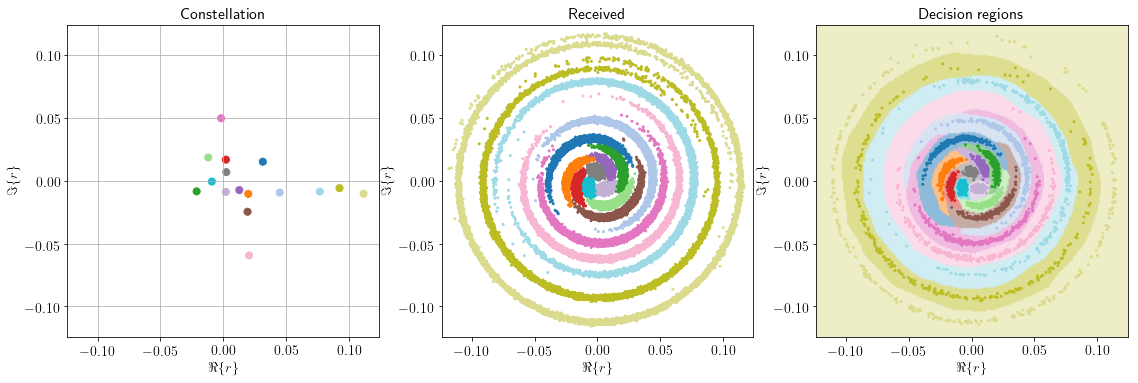

In [8]:
%matplotlib inline
plt.figure(figsize=(19,6))
font = {'size'   : 14}
plt.rc('font', **font)
plt.rc('text', usetex=True)
    
plt.subplot(131)
plt.scatter(constellations[min_SER_iter][:,0], constellations[min_SER_iter][:,1], c=range(M), cmap='tab20',s=50)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.grid(which='both')
plt.title('Constellation',fontsize=16)

plt.subplot(132)
#plt.contourf(mgx,mgy,decision_region_evolution[-1].reshape(mgy.shape).T,cmap='coolwarm',vmin=0.3,vmax=0.7)
plt.scatter(validation_received[min_SER_iter][:,0], validation_received[min_SER_iter][:,1], c=y_valid, cmap='tab20',s=4)
plt.axis('scaled')
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.title('Received',fontsize=16)

plt.subplot(133)
decision_scatter = np.argmax(decision_region_evolution[min_SER_iter], 1)
plt.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
plt.scatter(validation_received[min_SER_iter][0:4000,0], validation_received[min_SER_iter][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
plt.axis('scaled')
plt.xlim((-ext_max_plot,ext_max_plot))
plt.ylim((-ext_max_plot,ext_max_plot))
plt.xlabel(r'$\Re\{r\}$',fontsize=14)
plt.ylabel(r'$\Im\{r\}$',fontsize=14)
plt.title('Decision regions',fontsize=16)

#plt.savefig('decision_region_AE_Pin%d.pdf' % Pin,bbox_inches='tight')

Generate animation and save as a gif.

<IPython.core.display.Javascript object>


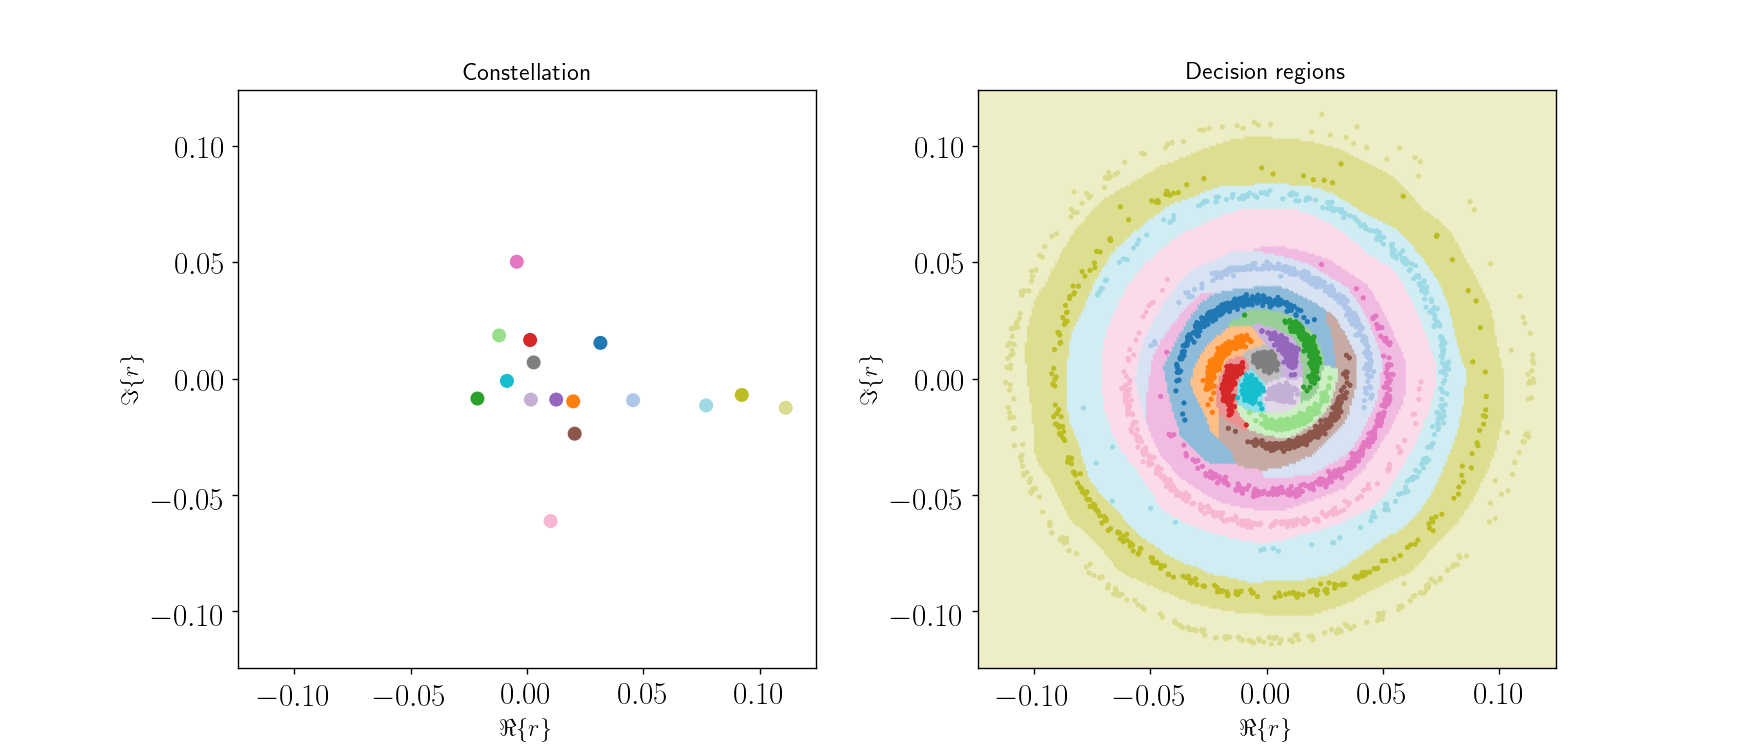

In [9]:
%matplotlib notebook
%matplotlib notebook
# Generate animation
from matplotlib import animation, rc
from matplotlib.animation import PillowWriter # Disable if you don't want to save any GIFs.

font = {'size'   : 18}
plt.rc('font', **font)

fig = plt.figure(figsize=(14,6))
ax1 = fig.add_subplot(1,2,1)
ax2 = fig.add_subplot(1,2,2)

ax1.axis('scaled')
ax2.axis('scaled')

written = False
def animate(i):
    ax1.clear()
    ax1.scatter(constellations[i][:,0], constellations[i][:,1], c=range(M), cmap='tab20',s=50)

    ax2.clear()
    #ax2.scatter([0,0.02],[0.02,0], c=[1,2], cmap='tab20',s=100)
    #decision_scatter = np.argmax(decision_region_evolution[i], 1)
    decision_scatter = np.argmax(decision_region_evolution[i], 1)
    ax2.scatter(meshgrid[:,0], meshgrid[:,1], c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4)
    ax2.scatter(validation_received[i][0:4000,0], validation_received[i][0:4000,1], c=y_valid[0:4000], cmap='tab20',s=4)
    
    #plt.scatter(meshgrid[:,0] * ext_max,meshgrid[:,1] * ext_max, c=decision_scatter, cmap=matplotlib.colors.ListedColormap(colors=new_color_list),s=4, marker='s')
    #plt.scatter(X_valid[0:4000,0]*ext_max, X_valid[0:4000,1]*ext_max, c=y_valid[0:4000], cmap='tab20',s=4)
    ax1.set_xlim(( -ext_max_plot, ext_max_plot))
    ax1.set_ylim(( -ext_max_plot, ext_max_plot))
    ax2.set_xlim(( -ext_max_plot, ext_max_plot))
    ax2.set_ylim(( -ext_max_plot, ext_max_plot))
    ax1.set_title('Constellation', fontsize=14)
    ax2.set_title('Decision regions', fontsize=14)
    
    ax1.set_xlabel(r'$\Re\{r\}$',fontsize=14)
    ax1.set_ylabel(r'$\Im\{r\}$',fontsize=14)
    ax2.set_xlabel(r'$\Re\{r\}$',fontsize=14)
    ax2.set_ylabel(r'$\Im\{r\}$',fontsize=14)

    
anim = animation.FuncAnimation(fig, animate, frames=min_SER_iter+1, interval=200, blit=False)
fig.show()
#anim.save('learning_decision_AE_Pin%d_varbatch.gif' % Pin, writer=PillowWriter(fps=5))